In [1]:
import pandas as pd
import numpy as np
import sys, os
from importlib import reload

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from analysis.evaluator import ModelEvaluator

## Load data and evaluate model

In [2]:
df = pd.read_csv("../data/bank-full.csv", delimiter=';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# Convert 'y' to numeric for analysis
df["target"] = np.where(df["y"] == "no", 0, 1)

# Add weights to test weight functionality of plot_target_vs_predictors()
df["weights"] = np.abs(np.random.randn(len(df.index)))

# Add an arbitrary data split for testing functions
df["random"] = np.random.uniform(0, 1, len(df.index))
df["split"] = np.where(df["random"]  > 0.70, "V", "T")

In [5]:
df["split"].value_counts(dropna=False, normalize=True)

split
T    0.701157
V    0.298843
Name: proportion, dtype: float64

In [6]:
df.groupby("split")["target"].mean()

split
T    0.117256
V    0.116350
Name: target, dtype: float64

### Add GLM and GBM predictions for testing functions

In [7]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [8]:
# Split data; define features and target
X = df.drop(columns=["y", "split", "target"])
X_train = df.query("split == 'T'").drop(columns=["y", "split", "target"])
X_test = df.query("split == 'V'").drop(columns=["y", "split", "target"])
y_train = df.query("split == 'T'")["target"]
y_test = df.query("split == 'V'")["target"]

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# GLM model
glm_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(solver='liblinear'))
])
glm_pipeline.fit(X_train, y_train)
df["pred_glm"] = glm_pipeline.predict_proba(X)[:, 1]

# XGBoost model
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])
xgb_pipeline.fit(X_train, y_train)
df["pred_xgb"] = xgb_pipeline.predict_proba(X)[:, 1]


In [9]:
df[["pred_glm", "pred_xgb", "target"]].describe()

,pred_glm,pred_xgb,target
count,45211.000000,45211.000000,45211.000000
mean,0.118057,0.115601,0.116985
std,0.188663,0.229825,0.321406
min,0.000060,0.000002,0.000000
25%,0.020736,0.001050,0.000000
50%,0.044387,0.007653,0.000000
75%,0.109919,0.082313,0.000000
max,1.000000,0.994180,1.000000


## plot_target_vs_predictors function

In [10]:
predictors =  ["job", "balance", "contact", "duration", "marital", "job", "pdays", "previous"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:302: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45, ha="right")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:302: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45, ha="right")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum

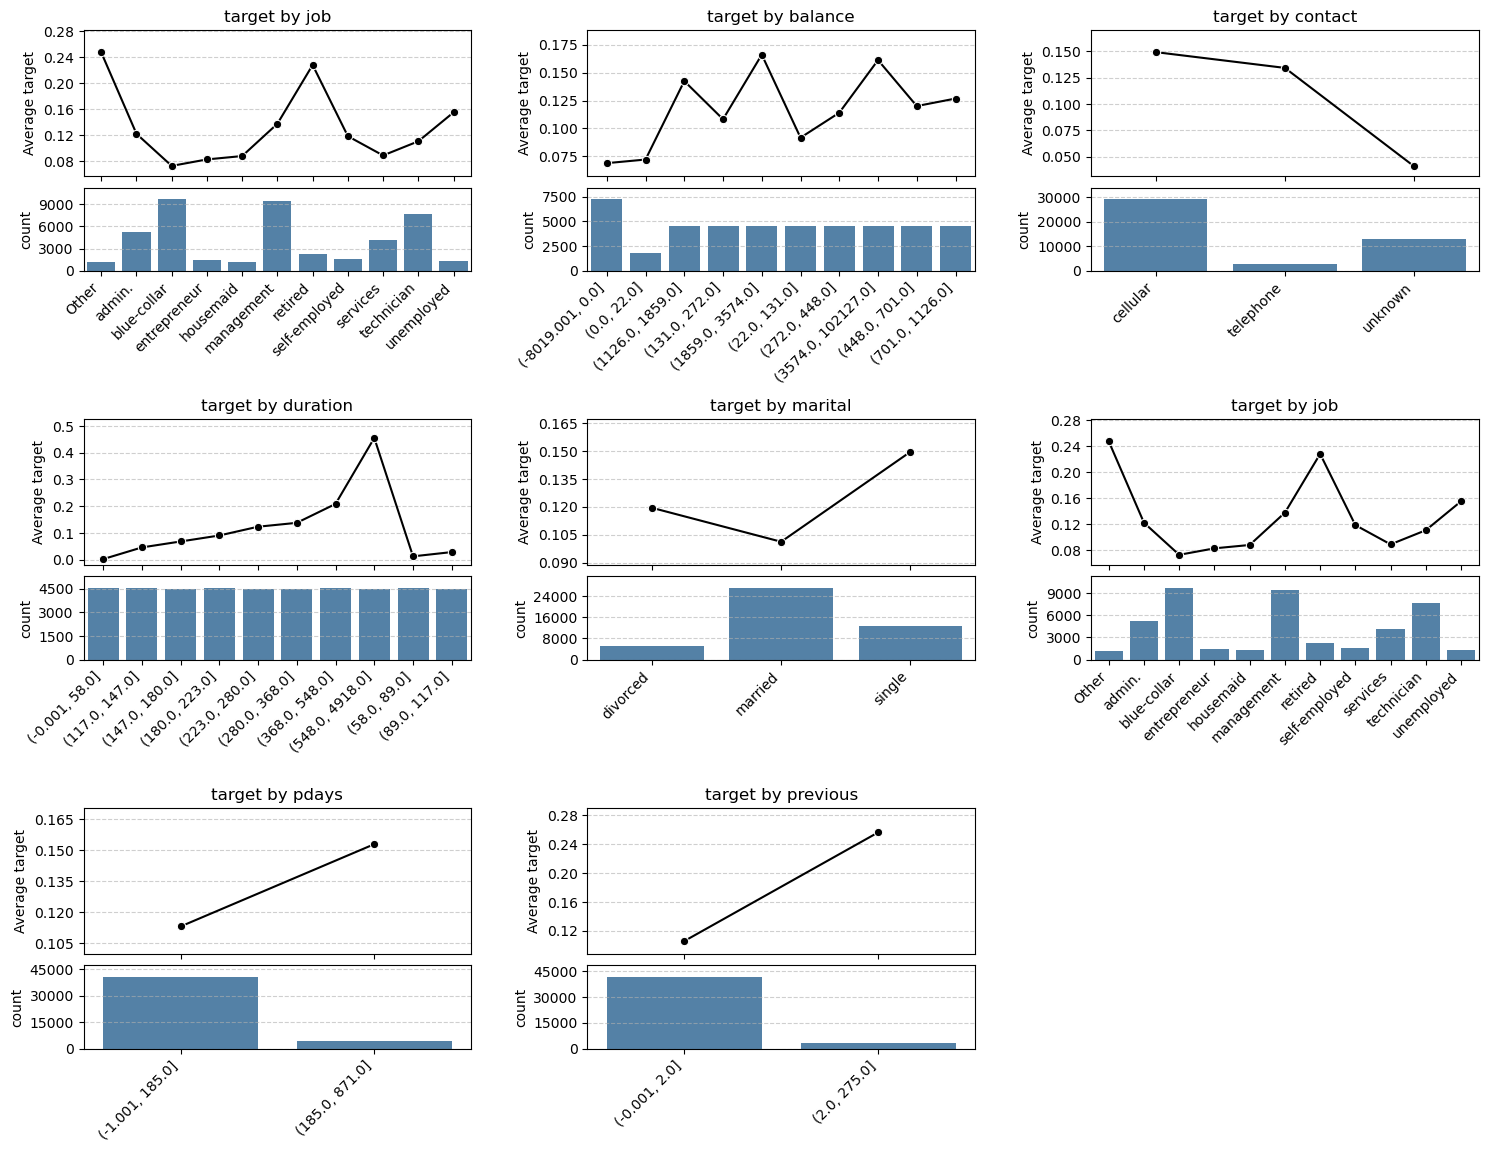

In [11]:
from analysis.plots import plot_target_vs_predictors
plot_target_vs_predictors(df, "target", predictors)

/home/sagemaker-user/analysis-tools/src/analysis/plots.py:284: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:302: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45, ha="right")
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:284: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:302: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45, ha="right")
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:284: UserWarning: The palette list has more values (10) than n

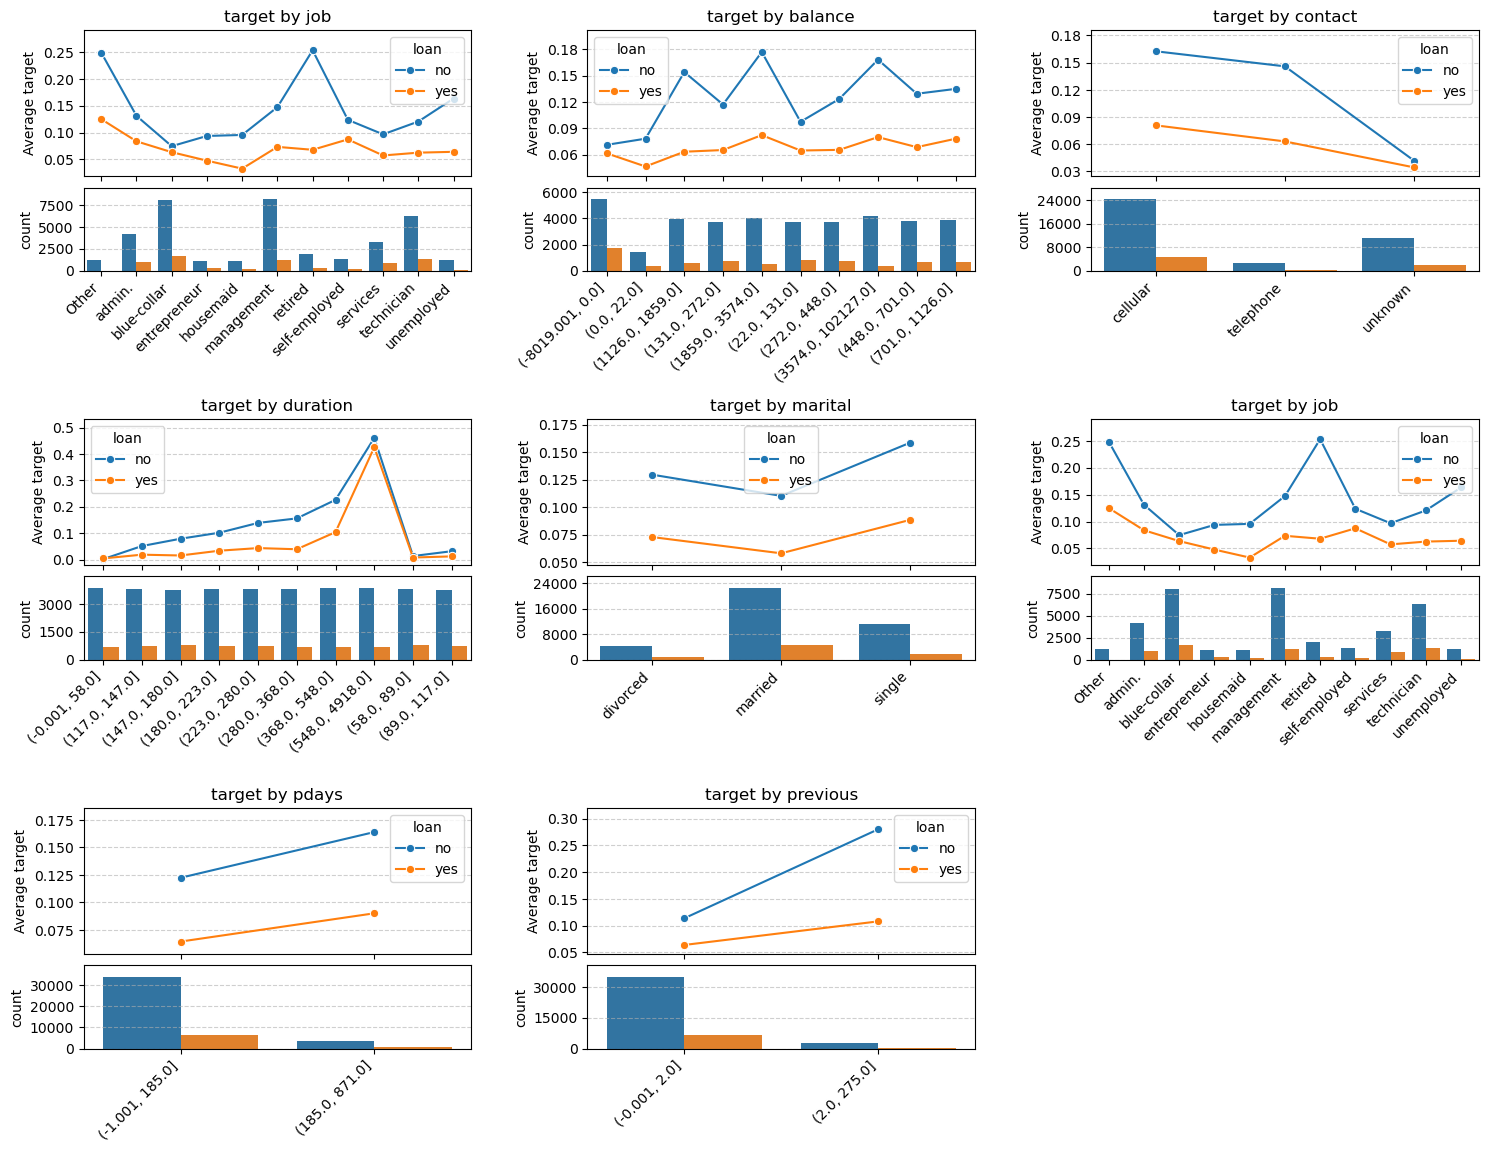

In [12]:
from analysis.plots import plot_target_vs_predictors
plot_target_vs_predictors(df, "target", predictors, group_col="loan");

## Error plots

/home/sagemaker-user/analysis-tools/src/analysis/plots.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data.groupby("bin")[group_col].mean()
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(group_col_final).agg(
/home/sagemaker-user/analysis-tools/src/an

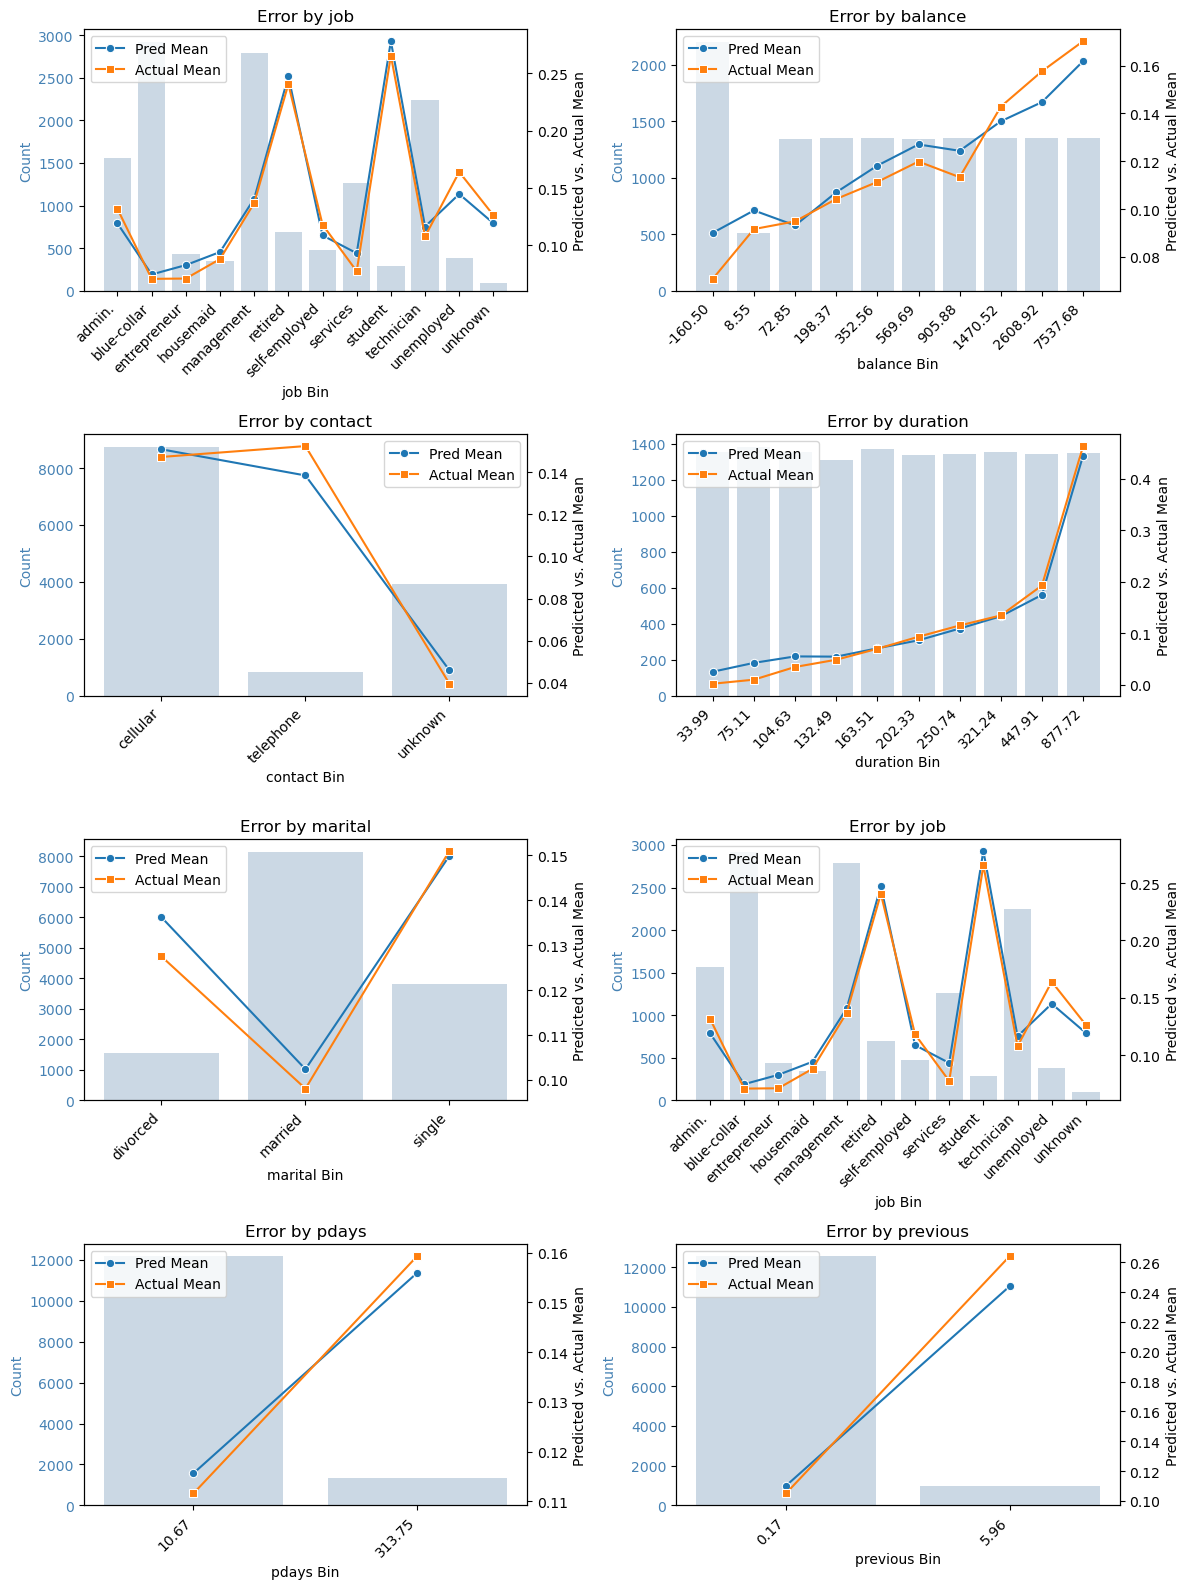

In [13]:
from analysis.plots import plot_error_by_group_grid
plot_error_by_group_grid(
    df.query("split == 'V'"), 
    "target", 
    "pred_glm", 
    predictors, 
    bins=10
    )

/home/sagemaker-user/analysis-tools/src/analysis/plots.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data.groupby("bin")[group_col].mean()
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(group_col_final).agg(
/home/sagemaker-user/analysis-tools/src/an

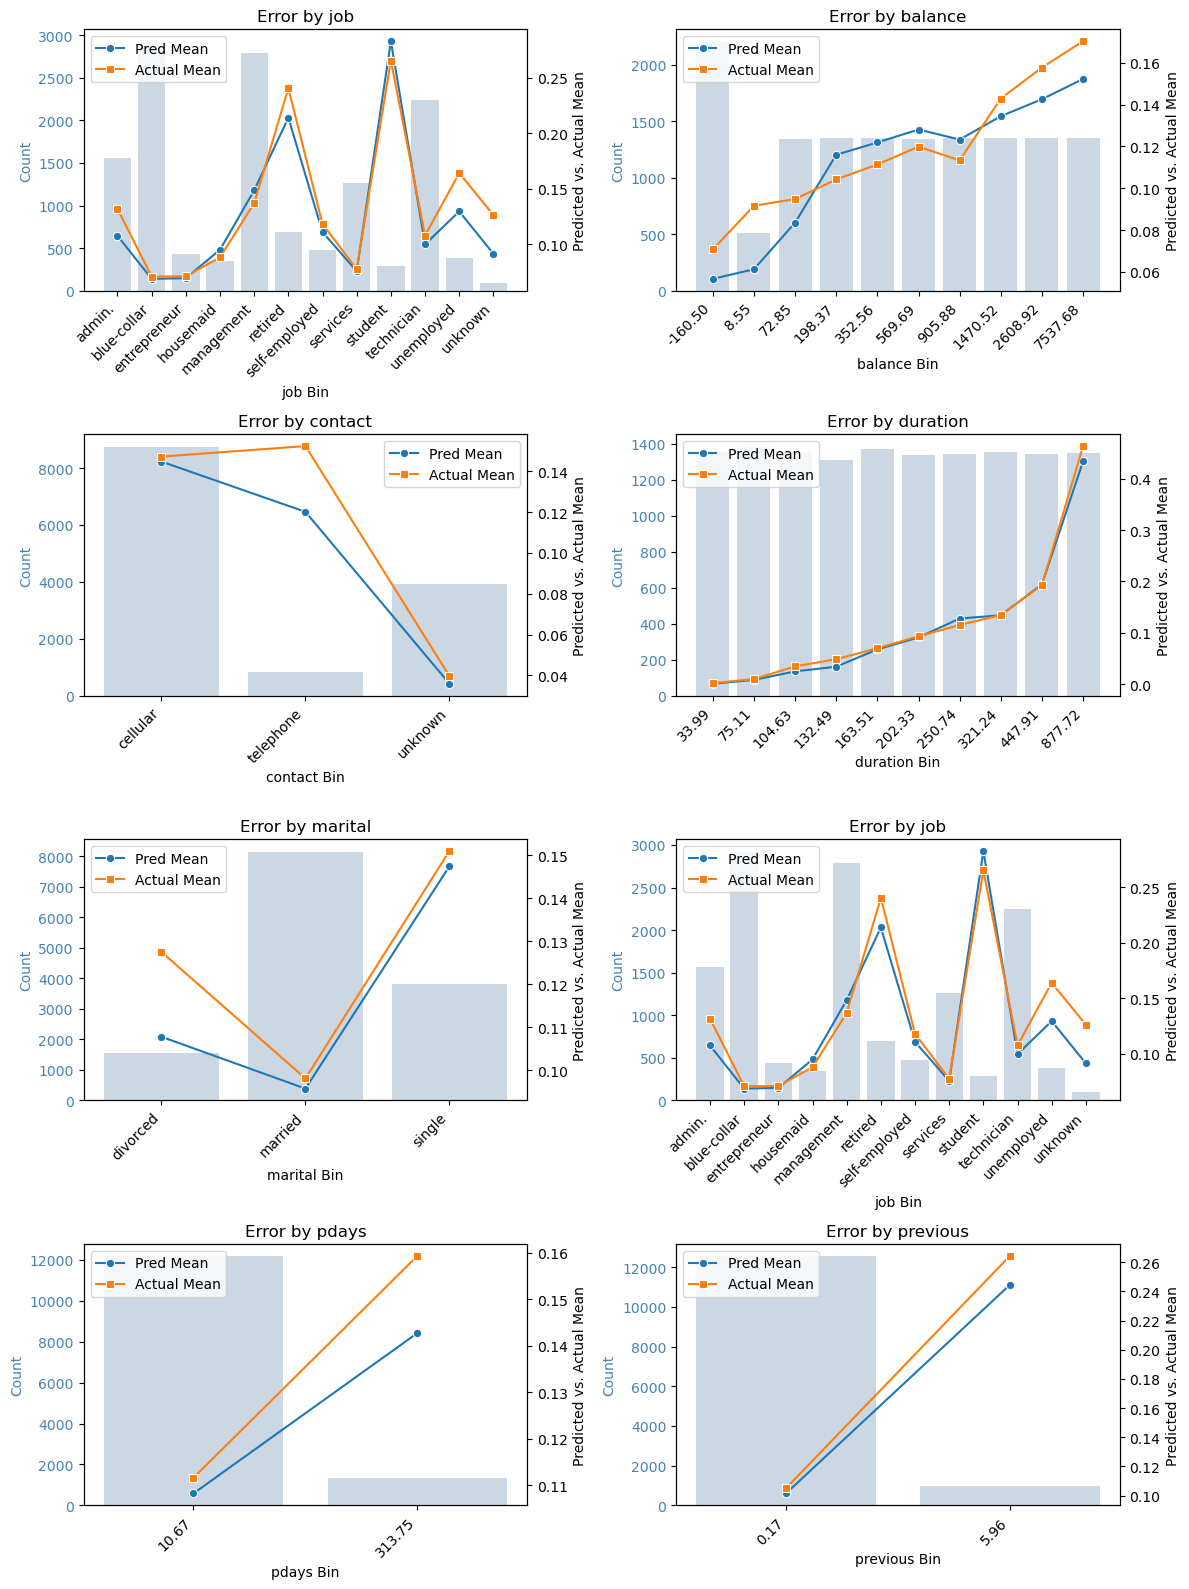

In [14]:
plot_error_by_group_grid(
    df.query("split == 'V'"), 
    "target", 
    "pred_xgb", 
    predictors, 
    bins=10
    )

## Explore creation of tabulation function and object

In [15]:
from analysis.evaluator import ModelEvaluator

In [16]:
me = ModelEvaluator(
        data=df,
        actual_col="target",
        predicted_col="pred_glm",
)

In [17]:
me.compare_models_discrepancy("pred_xgb")

,target,pred_glm,pred_xgb,abs_diff
24129,1,0.019226,0.988962,0.969737
29182,0,0.985664,0.029042,0.956622
24143,1,0.016515,0.964963,0.948448
24090,1,0.027589,0.972276,0.944686
43839,0,0.994713,0.053390,0.941322
44390,1,0.040618,0.978921,0.938302
24174,1,0.008020,0.933490,0.925470
41893,0,0.995236,0.072910,0.922326
24159,1,0.014078,0.929021,0.914943
41297,1,0.067279,0.981875,0.914596


In [18]:
me.export_html("test.html", residual_fit_kwargs={"residual_type": "normalized"})

/home/sagemaker-user/analysis-tools/src/analysis/report.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("bin")
/home/sagemaker-user/analysis-tools/src/analysis/report.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("bin")
/home/sagemaker-user/analysis-tools/src/analysis/report.py:256: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("group")
/home/sagemaker-user/analysis-tools/sr

✅ Analysis report generated at test.html
